# Mathieu equation

strong form of the problem 
$$
\begin{align*}
&\text{Find $u(\textbf{x}): \Omega \to \mathbb{R}$ such that } \\
&\begin{cases}
-\nabla^2u + 2q\cos(\textbf{k}\cdot\textbf{x}) u = \lambda u & \forall\textbf{x}\in\Omega \\
u=u_{\text{D}} & \forall \textbf{x}\in\partial\Omega_{\text{D}} \\
\textbf{n}\cdot\nabla{u} = u_{\text{N}} & \forall\textbf{x}\in\partial\Omega_{\text{N}}=\partial\Omega/\partial\Omega_{\text{D}}
\end{cases}~.
\end{align*}
$$

weak form of the eigenvalue problem (if $\partial\Omega_{\text{N}}=\varnothing$)
$$
\begin{align*}
&\text{Find $u\in V$ and $\lambda\in\mathbb{C}$ such that }\\
&L(u, v)=\lambda R(u,v) \quad\forall v\in V \\
&\text{where }\\
&L(u, v) = \int_\Omega\text{d}\Omega~\nabla v\cdot\nabla u + 2q\cos(\textbf{k}\cdot\textbf{x}) vu\\
&R(u,v) = \int_\Omega\text{d}\Omega~vu \\
\end{align*}
$$

## Example: Mathieu equation on an interval

$$
\mathbb{S}=
\begin{cases}
\Omega = [0, L_x] \\
\textbf{k}=2\,\textbf{e}_x \\
u_{\text{D}}\vert_{\partial\Omega}=0 \\
q=0\implies u_{\text{e}, n}(x)=\sin(\sqrt{\lambda_{\text{e}, n}}x)~,~\lambda_{\text{e}, n}=\frac{n^2\pi^2}{L_x^2}
\end{cases}
$$

In [ ]:
import numpy as np
from dolfinx.fem import FunctionSpace

from lucifex.mesh import interval_mesh
from lucifex.fem import Constant
from lucifex.solver import evp, EigenvalueProblem, BoundaryConditions, OptionsSLEPc
from lucifex.viz import plot_line, create_cycler
from lucifex.io import write, get_ipynb_file_name
from lucifex.pde.eigen import mathieu


def create_mathieu_solver(
    Lx: float,
    Nx: int,
    bcs: BoundaryConditions, 
    q: float,
    k: float,
    nev: int,
) -> EigenvalueProblem:
    mesh = interval_mesh(Lx, Nx)
    q = Constant(mesh, q)
    k = Constant(mesh, (k, ))

    fs = FunctionSpace(mesh, ('P', 1))
    slepc = OptionsSLEPc(
        eps_tol=1e-10,
        eps_target=0.0,
        eps_nev=nev,
        eps_ncv=50,
        eps_max_it=1000,
        eps_which='smallest_real',
    )
    u_solver = evp(mathieu, bcs, slepc)(fs, q, k)
    return u_solver


Lx = 1.0
Nx = 200
bcs = BoundaryConditions(
        ('dirichlet', lambda x: x[0], 0.0),
        ('dirichlet', lambda x: x[0] - Lx, 0.0),
    )
nev = 4
k = 2.0

q_axis = np.linspace(0, 20, num=10)
solvers = [create_mathieu_solver(Lx, Nx, bcs, q, k, nev) for q in q_axis]

In [9]:
[s.solve() for s in solvers]
eigenvalues = [s.eigenvalues for s in solvers]
eigenreals = [[np.real(l) for l in lmbdas] for lmbdas in eigenvalues]
eigenreals_q0 = [(n * np.pi/ Lx) ** 2 for n in range(nev)]

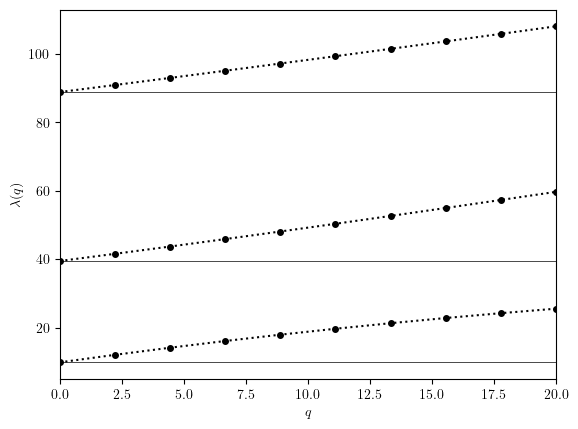

In [ ]:
lines = [
    (q_axis, [eigenreals[q_index][n] for q_index in range(len(q_axis))])
    for n in range(nev)
]
cyc = create_cycler(linestyle=['dashed'], marker=['o'], ms=[4], color=['black'])
slc = slice(1, None)
fig, ax = plot_line(
    lines[slc], 
    cyc=cyc,
    x_label='$q$', 
    y_label='$\lambda(q)$')
ax.set_xlim(q_axis[0], q_axis[-1])
ax.hlines(eigenreals_q0[slc], q_axis[0], q_axis[-1], color='black', lw=0.5, ls='-')
ax.set_yscale('log')
write(fig, get_ipynb_file_name(), './figures', close=False, pickle=False)